In [37]:
pip install huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.


In [38]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# load the model

In [40]:
model_name="facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [41]:
device

'cpu'

In [42]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device,
    )
    return theme_classifier

In [43]:
theme_classifier = load_model(device)

Device set to use cpu


In [44]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [45]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'betrayal',
  'love',
  'friendship'],
 'scores': [0.9121254682540894,
  0.4750021696090698,
  0.08781802654266357,
  0.045000310987234116,
  0.020132873207330704,
  0.012040517292916775,
  0.004292406607419252,
  0.00281721749342978]}

In [46]:
files = glob('../data/subtitles/*.srt')

In [47]:
files[:5]

['../data/subtitles\\Breaking Bad - 1x01 - Pilot.DVDRip.ORPHEUS.en.srt',
 "../data/subtitles\\Breaking Bad - 1x02 - Cat's in the Bag....DVDRip.ORPHEUS.en.srt",
 "../data/subtitles\\Breaking Bad - 1x03 - ...and the Bag's in the River.DVDRip.ORPHEUS.en.srt",
 '../data/subtitles\\Breaking Bad - 1x04 - Cancer Man.DVDRip.ORPHEUS.en.srt',
 '../data/subtitles\\Breaking Bad - 1x05 - Gray Matter.DSR.LOL.en.srt']

In [48]:
import os
import re

def clean_subtitle_file(input_path, output_path):
    with open(input_path, "r", encoding="utf-8", errors="ignore") as f:
        content = f.read()

    # Remove specific unwanted lines
    patterns_to_remove = [
        r"<font.*?>www\.tvsubtitles\.net<\/font>",   # Remove tvsubtitles.net watermark
        r"<i>Previously on.*?<\/i>",                 # Remove "Previously on..."
        r"Last season on.*",                         # Remove "Last season on..."
        r"Sync by honeybunny.*",                     # Remove sync credit
        r"www\.addic7ed\.com.*",                     # Remove addic7ed.com watermark
        r"www\.tvsubtitles\.net.*",                  # Remove tvsubtitles.net plain text
        r"^\d+\s*$",                                 # Remove subtitle numbering lines
    ]

    for pattern in patterns_to_remove:
        content = re.sub(pattern, "", content, flags=re.IGNORECASE | re.MULTILINE)

    # Remove subtitle timing lines like: 00:00:0,500 --> 00:00:2,00
    content = re.sub(
        r"\d{2}:\d{2}:\d{1,2},\d{3}\s*-->\s*\d{2}:\d{2}:\d{1,2},\d{3}.*",
        "",
        content
    )

    # Remove extra blank lines
    content = re.sub(r"\n\s*\n", "\n", content).strip()

    # Save cleaned content to new file
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(content)


def clean_all_subtitles(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    for filename in os.listdir(input_folder):
        if filename.endswith(".srt"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            clean_subtitle_file(input_path, output_path)
            print(f"Cleaned: {filename}")


# Paths
input_folder = "../data/subtitles"
output_folder = "../data/subtitles-cleaned"

clean_all_subtitles(input_folder, output_folder)







Cleaned: Breaking Bad - 1x01 - Pilot.DVDRip.ORPHEUS.en.srt
Cleaned: Breaking Bad - 1x02 - Cat's in the Bag....DVDRip.ORPHEUS.en.srt
Cleaned: Breaking Bad - 1x03 - ...and the Bag's in the River.DVDRip.ORPHEUS.en.srt
Cleaned: Breaking Bad - 1x04 - Cancer Man.DVDRip.ORPHEUS.en.srt
Cleaned: Breaking Bad - 1x05 - Gray Matter.DSR.LOL.en.srt
Cleaned: Breaking Bad - 1x06 - Crazy Handful of Nothin'.DSR.LOL.en.srt
Cleaned: Breaking Bad - 1x07 - A-No-Rough-Stuff-Type-Deal.DSR.LOL.en.srt
Cleaned: Breaking Bad - 2x01 - Seven Thirty-Seven.720p HDTV.CTU.en.srt
Cleaned: Breaking Bad - 2x02 - Grilled.HDTV.0TV.en.srt
Cleaned: Breaking Bad - 2x03 - Bit by a Dead Bee.HDTV.0TV.en.srt
Cleaned: Breaking Bad - 2x04 - Down.HDTV.0TV.en.srt
Cleaned: Breaking Bad - 2x05 - Breakage.HDTV.FQM.en.srt
Cleaned: Breaking Bad - 2x06 - Peekaboo.HDTV.0TV.en.srt
Cleaned: Breaking Bad - 2x07 - Negro Y Azul.HDTV.FQM.en.srt
Cleaned: Breaking Bad - 2x08 - Better Call Saul.720p HDTV.CTU.en.srt
Cleaned: Breaking Bad - 2x09 - 4 Da

In [49]:
files[0]

'../data/subtitles\\Breaking Bad - 1x01 - Pilot.DVDRip.ORPHEUS.en.srt'

In [50]:

episode = int(re.search(r"x(\d{2})", files[0]).group(1))

In [51]:
episode

1

In [52]:
import os
import re
import pandas as pd

path = "../data/subtitles-cleaned"

data = []

for filename in os.listdir(path):
    if filename.endswith(".srt"):
        # Capture season and episode like 1x01, 2x03, etc.
        match = re.search(r"(\d+)x(\d{2})", filename)
        if match:
            season = int(match.group(1))
            episode = int(match.group(2))

            with open(os.path.join(path, filename), "r", encoding="utf-8") as f:
                script = " ".join(line.strip() for line in f if line.strip())

            data.append({"season": season, "episode": episode, "script": script})

df = pd.DataFrame(data, columns=["season", "episode", "script"])

# Sort properly: first by season, then by episode
df = df.sort_values(by=["season", "episode"]).reset_index(drop=True)

print(df.head())



   season  episode                                             script
0       1        1  Oh, my god. Christ! Shit. Oh, God. Oh, my God....
1       1        2  Are you okay? - You are a lifesaver. - Yeah, m...
2       1        3  <i>Let's break it down. </i> Hydrogen. What do...
3       1        4  Operation Icebreaker. - How we liking that? - ...
4       1        5  Here's my rsum. I mean, technically it says "c...


In [53]:
df.head(10)

,season,episode,script
0,1,1,"Oh, my god. Christ! Shit. Oh, God. Oh, my God...."
1,1,2,"Are you okay? - You are a lifesaver. - Yeah, m..."
2,1,3,<i>Let's break it down. </i> Hydrogen. What do...
3,1,4,Operation Icebreaker. - How we liking that? - ...
4,1,5,"Here's my rsum. I mean, technically it says ""c..."
5,1,6,"Let's get something straight. This, the chemis..."
6,1,7,"In closing, I can tell you we take this very s..."
7,2,1,<i> Chemistry is the study of change. You unde...
8,2,2,"Synch: Tyno, Michvanilly www.forom.com www.sub..."
9,2,3,"It's a bold plan, Mr. White. You sure this is ..."


## run the model

In [54]:
script=df.iloc[0]['script']

In [55]:
script

'Oh, my god. Christ! Shit. Oh, God. Oh, my God. Oh, my God. Oh, my God. Think, think, think. Oh, my gosh. Okay. Come on, come on, come on. Come on. My name is Walter Hartwell White. I live at 308 Negra Arroyo Lane, Albuquerque, New Mexico, 87104. To all law-enforcement entities, this is not an admission of guilt. I am speaking to my family now. Skyler. You are the love of my life. I hope you know that. Walter Jr. You\'re my big man. There are... There are going to be some things... Things that you\'ll come to learn about me... ...in the next few days. I just want you to know that no matter how it may look... ...I only had you in my heart. Goodbye. <i>Money before the panel earlier this year. </i> Happy birthday. Look at that. That is veggie bacon. Believe it or not. Zero cholesterol... ...and you won\'t even taste the difference. What time do you think you\'ll be home? Same time. I don\'t want him dicking you around tonight. You get paid till 5, you work till 5. No later. Hey. - Hey, h

In [59]:
import nltk

# Download to a known directory
nltk.download('punkt', download_dir=r'C:\nltk_data')


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
import nltk
nltk.data.path.append(r'C:\nltk_data')  # Add the folder to NLTK’s search path


In [61]:
from nltk.data import find
find('tokenizers/punkt')  # Should print the path instead of throwing an error


FileSystemPathPointer('C:\\Users\\user\\AppData\\Roaming\\nltk_data\\tokenizers\\punkt')

In [65]:
import nltk

# Add the exact path where punkt was downloaded
nltk.data.path.append(r'C:\Users\user\AppData\Roaming\nltk_data')

# Download missing punkt_tab resource
nltk.download('punkt_tab', download_dir=r'C:\Users\user\AppData\Roaming\nltk_data')

# Optional: verify NLTK can find punkt
from nltk.data import find
print(find('tokenizers/punkt'))




C:\Users\user\AppData\Roaming\nltk_data\tokenizers\punkt


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [68]:
# Now you can safely tokenize
from nltk.tokenize import sent_tokenize

script_sentences = sent_tokenize(script)
print(script_sentences[:50])

['Oh, my god.', 'Christ!', 'Shit.', 'Oh, God.', 'Oh, my God.', 'Oh, my God.', 'Oh, my God.', 'Think, think, think.', 'Oh, my gosh.', 'Okay.', 'Come on, come on, come on.', 'Come on.', 'My name is Walter Hartwell White.', 'I live at 308 Negra Arroyo Lane, Albuquerque, New Mexico, 87104.', 'To all law-enforcement entities, this is not an admission of guilt.', 'I am speaking to my family now.', 'Skyler.', 'You are the love of my life.', 'I hope you know that.', "Walter Jr. You're my big man.", 'There are...', 'There are going to be some things...', "Things that you'll come to learn about me... ...in the next few days.", 'I just want you to know that no matter how it may look...', '...I only had you in my heart.', 'Goodbye.', '<i>Money before the panel earlier this year.', '</i> Happy birthday.', 'Look at that.', 'That is veggie bacon.', 'Believe it or not.', "Zero cholesterol... ...and you won't even taste the difference.", "What time do you think you'll be home?", 'Same time.', "I don't 

In [69]:
#batch sentence
sentence_batch_size=20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)
    

In [70]:
script_batches[:2]

["Oh, my god. Christ! Shit. Oh, God. Oh, my God. Oh, my God. Oh, my God. Think, think, think. Oh, my gosh. Okay. Come on, come on, come on. Come on. My name is Walter Hartwell White. I live at 308 Negra Arroyo Lane, Albuquerque, New Mexico, 87104. To all law-enforcement entities, this is not an admission of guilt. I am speaking to my family now. Skyler. You are the love of my life. I hope you know that. Walter Jr. You're my big man.",
 "There are... There are going to be some things... Things that you'll come to learn about me... ...in the next few days. I just want you to know that no matter how it may look... ...I only had you in my heart. Goodbye. <i>Money before the panel earlier this year. </i> Happy birthday. Look at that. That is veggie bacon. Believe it or not. Zero cholesterol... ...and you won't even taste the difference. What time do you think you'll be home? Same time. I don't want him dicking you around tonight. You get paid till 5, you work till 5. No later. Hey. - Hey, h

In [71]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [72]:
theme_output

[{'sequence': "Oh, my god. Christ! Shit. Oh, God. Oh, my God. Oh, my God. Oh, my God. Think, think, think. Oh, my gosh. Okay. Come on, come on, come on. Come on. My name is Walter Hartwell White. I live at 308 Negra Arroyo Lane, Albuquerque, New Mexico, 87104. To all law-enforcement entities, this is not an admission of guilt. I am speaking to my family now. Skyler. You are the love of my life. I hope you know that. Walter Jr. You're my big man.",
  'labels': ['love',
   'dialogue',
   'self development',
   'friendship',
   'hope',
   'sacrifice',
   'battle',
   'betrayal'],
  'scores': [0.9365633726119995,
   0.6835274696350098,
   0.6001949310302734,
   0.5634819865226746,
   0.5497030019760132,
   0.4417339265346527,
   0.34580981731414795,
   0.16317866742610931]},
 {'sequence': "There are... There are going to be some things... Things that you'll come to learn about me... ...in the next few days. I just want you to know that no matter how it may look... ...I only had you in my h

In [73]:
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [75]:
themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

In [76]:
themes

{'love': np.float64(0.7269890308380127),
 'dialogue': np.float64(0.7970314025878906),
 'self development': np.float64(0.753075122833252),
 'friendship': np.float64(0.677779346704483),
 'hope': np.float64(0.5082028210163116),
 'sacrifice': np.float64(0.5611232966184616),
 'battle': np.float64(0.37212900817394257),
 'betrayal': np.float64(0.17746704071760178)}

In [79]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [80]:
df = df.head(2)

In [81]:
df

,season,episode,script
0,1,1,"Oh, my god. Christ! Shit. Oh, God. Oh, my God...."
1,1,2,"Are you okay? - You are a lifesaver. - Yeah, m..."


In [82]:
output_themes = df['script'].apply(get_themes_inference)

In [83]:
output_themes

0    {'love': 0.7269890308380127, 'dialogue': 0.797...
1    {'dialogue': 0.9539689719676971, 'sacrifice': ...
Name: script, dtype: object

In [84]:
theme_df = pd.DataFrame(output_themes.tolist())

In [85]:
theme_df

,love,dialogue,self development,friendship,hope,sacrifice,battle,betrayal
0,0.726989,0.797031,0.753075,0.677779,0.508203,0.561123,0.372129,0.177467
1,0.292626,0.953969,0.748378,0.529181,0.511179,0.854497,0.577626,0.588857


In [86]:
df

,season,episode,script
0,1,1,"Oh, my god. Christ! Shit. Oh, God. Oh, my God...."
1,1,2,"Are you okay? - You are a lifesaver. - Yeah, m..."


In [87]:
df[theme_df.columns] = theme_df
df

,season,episode,script,love,dialogue,self development,friendship,hope,sacrifice,battle,betrayal
0,1,1,"Oh, my god. Christ! Shit. Oh, God. Oh, my God....",0.726989,0.797031,0.753075,0.677779,0.508203,0.561123,0.372129,0.177467
1,1,2,"Are you okay? - You are a lifesaver. - Yeah, m...",0.292626,0.953969,0.748378,0.529181,0.511179,0.854497,0.577626,0.588857


In [97]:
df = df.drop('season',axis=1)

In [100]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,love,1.019615
1,self development,1.501453
2,friendship,1.206961
3,hope,1.019382
4,sacrifice,1.415620
5,battle,0.949755
6,betrayal,0.766324


In [101]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

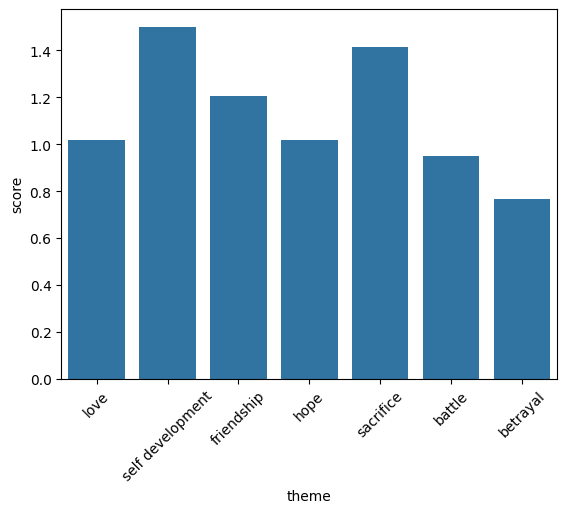

In [103]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()

